## Import Libraries and Data

In [28]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import scipy.spatial.distance as dist
import sys

# Add modules directory to sys path
sys.path.append('./src/modules/')

# Import local modules
import EDA, model

In [2]:
# Load modeling dataset and RGB tuples

df = pd.read_csv('./src/data/model_data.csv')
colordf = pd.read_csv('./src/data/colors.csv')

In [3]:
# Re-instate the proper index- it's not sequential due to dropped NaN rows but corresponds to the names of the image data
df.set_index('Unnamed: 0', inplace = True)
colordf.set_index('Unnamed: 0', inplace = True)

# Convert the color tuples back to int
colordf['0'] = colordf['0'].apply(lambda x: eval(x))
colordf['1'] = colordf['1'].apply(lambda x: eval(x))
colordf['2'] = colordf['2'].apply(lambda x: eval(x))

In [4]:
# Create a variant DataFrame with just price, sizing info, number of likes and a binary vintage classifier
simple_df = df[['Price', 'L', 'M', 'S', 'XL', 'XS', 'XXL', 'FollowerCount', 'VINTAGE']]

# Create a second variant DataFrame with all features except color
kdf = df.drop(columns = ['0', '1', '2'])

In [5]:
# Scale both DataFrames using StandardScaler and turn back into DataFrames with the same column names
kcolumns = kdf.columns
scolumns = simple_df.columns

scaler = StandardScaler()

kdf = pd.DataFrame(scaler.fit_transform(kdf), columns=kcolumns)
simple_df = pd.DataFrame(scaler.fit_transform(simple_df), columns=scolumns)

## K-Means Clustering

In [6]:
# Instatiate and fit the model and make cluster assignments to my abbreviated data set

k_means = KMeans(n_clusters=12) 

k_means.fit(simple_df) 

cluster_assignments = k_means.predict(simple_df) 

In [7]:
# Check the CH score to see the quality in the separation of the clusters

print(calinski_harabasz_score(kdf, cluster_assignments))

52.14576310512905


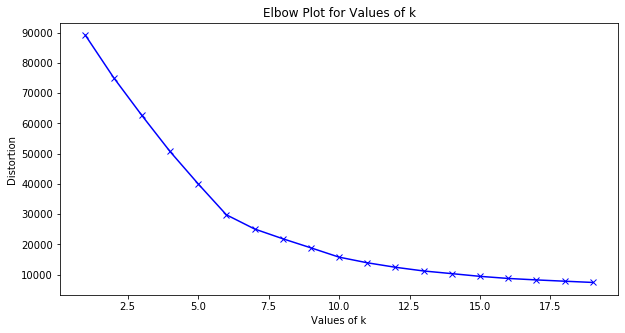

In [8]:
# Create an elbow plot to find the optimum value for K

clusters = []
K = range(1,20)
for k in K:
    kmm = KMeans(n_clusters=k)
    kmm.fit(simple_df)
    clusters.append(kmm.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, clusters, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Distortion')
plt.title('Elbow Plot for Values of k')
plt.show()

In [9]:
# Instantiate, fit and predict on the full data set and check the CH score for optimum clustering

k_means1 = KMeans(n_clusters = 18)

k_means1.fit(kdf)

cluster_assignments1 = k_means1.predict(kdf)

print(calinski_harabasz_score(kdf, cluster_assignments1))

157.28108273935658


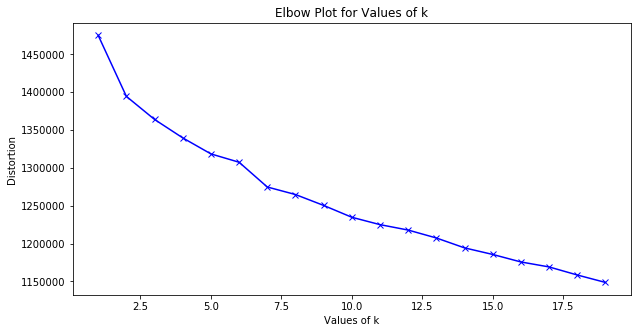

In [10]:
# Elbow plot to determine the optimal value for K

clusters = []
K = range(1,20)
for k in K:
    kmm = KMeans(n_clusters=k)
    kmm.fit(kdf)
    clusters.append(kmm.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, clusters, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Distortion')
plt.title('Elbow Plot for Values of k')
plt.show()

In [13]:
def cluster_recommendations(input_row, dataframe, n_clusters):
    kmm = KMeans(n_clusters= n_clusters)
    kmm.fit(dataframe)
    clusters = list(zip(list(dataframe.index), kmm.predict(dataframe) ))
    target = 0
    rec_list = []
    for i in clusters:
        if i[0] == input_row.index[0]:
            target == i[1]
            break
    for i in clusters:
        if i[1] == target:
            rec_list.append(i[0])
    return rec_list

In [77]:
# cluster_recommendations(simple_df.loc[127:127], simple_df, 8)

In [23]:
def display_kmeans_recs(input_row, dataframe, n_clusters):
    ''''''
    
    # Take indices from clusters with the target row
    indices = cluster_recommendations(input_row, dataframe, n_clusters)
    
    # Create an empty list and append the images from each indice to it, starting
    # with the input row
    images = []
    images.append(Image.open(f'./src/images/{input_row.index[0]}.jpg'))
    test_i = []
    for i in np.random.choice(indices, size=6, replace=False):
        images.append(Image.open(f'./src/images/{i}.jpg'))
        test_i.append(i)
    for i in test_i:
        print(f'Image {i} cosine similarity:', cosine_similarity(input_row, dataframe.loc[i:i]))
              
    print('Standard Deviation of likes in Recommendation Group:', dataframe['FollowerCount'][test_i].std())
    print('Difference in mean price and target item:', (input_row.Price - dataframe.Price[test_i].mean()))
              
    # Display the images
    fig, ax = plt.subplots(2, 3, figsize = (10,6))
    fig.suptitle('Similar items based on Clustering', size = 16)
    ax[0,0].imshow(images[0])
    ax[0,0].axis('off')
    ax[0,0].set_title('Original Image')
    ax[0,1].imshow(images[2])
    ax[0,1].axis('off')
    ax[0,1].set_title('Recommendation 1')
    ax[0,2].imshow(images[3])
    ax[0,2].axis('off')
    ax[0,2].set_title('Recommendation 2')
    ax[1,0].imshow(images[4])
    ax[1,0].axis('off')
    ax[1,0].set_title('Recommendation 3')
    ax[1,1].imshow(images[5])
    ax[1,1].axis('off')
    ax[1,1].set_title('Recommendation 4')
    ax[1,2].imshow(images[6])
    ax[1,2].axis('off')
    ax[1,2].set_title('Recommendation 5')
    plt.show()
    
    return 

Image 3638 cosine similarity: [[-0.13783541]]
Image 6251 cosine similarity: [[-0.13275285]]
Image 2653 cosine similarity: [[-0.19059915]]
Image 2944 cosine similarity: [[-0.14903577]]
Image 3501 cosine similarity: [[-0.17814844]]
Image 3102 cosine similarity: [[-0.18316036]]
Standard Deviation of likes in Recommendation Group: 0.511127860721276
Difference in mean price and target item: 127    1.119485
Name: Price, dtype: float64


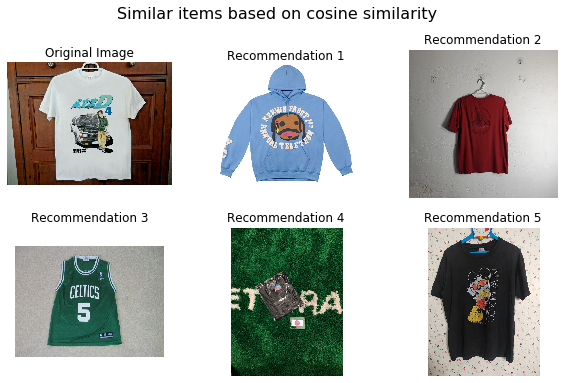

In [26]:
display_kmeans_recs(kdf.loc[127:127], kdf, n_clusters = 18)

Image 9544 cosine similarity: [[-0.34015224]]
Image 9380 cosine similarity: [[-0.17463203]]
Image 3799 cosine similarity: [[-0.43053228]]
Image 5751 cosine similarity: [[0.04417368]]
Image 6100 cosine similarity: [[-0.37775553]]
Image 1207 cosine similarity: [[-0.39213226]]
Standard Deviation of likes in Recommendation Group: 0.608054510513046
Difference in mean price and target item: 127    0.76699
Name: Price, dtype: float64


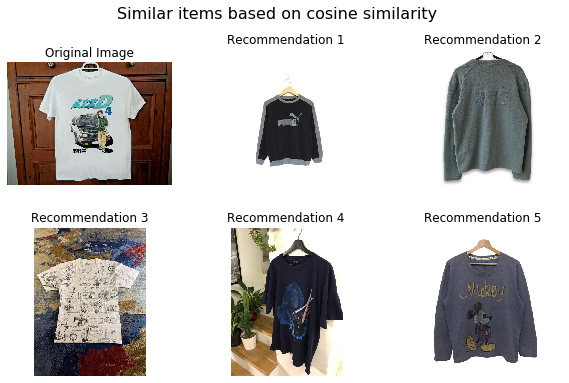

In [27]:
display_kmeans_recs(simple_df.loc[127:127], simple_df, n_clusters = 8)

## Principal Component Analysis

In [244]:
pca = PCA()
pca_df = pca.fit_transform(kdf)

In [245]:
np.cumsum(pca.explained_variance_ratio_)

array([0.07286296, 0.10075311, 0.12395509, 0.14548346, 0.16370005,
       0.18046169, 0.1965788 , 0.21094413, 0.22456818, 0.23757399,
       0.24998948, 0.26201755, 0.27360193, 0.28471134, 0.29557598,
       0.30560435, 0.31544913, 0.32505693, 0.33449911, 0.34384792,
       0.35291002, 0.36177291, 0.37042547, 0.37897199, 0.38740939,
       0.3957788 , 0.4040034 , 0.41209727, 0.42010139, 0.42792781,
       0.43571295, 0.44339182, 0.45090119, 0.45840286, 0.46587775,
       0.47328906, 0.48061567, 0.48787211, 0.49510458, 0.50228994,
       0.50939583, 0.51649544, 0.5235531 , 0.53060331, 0.53760595,
       0.54458656, 0.55152322, 0.55843287, 0.56533109, 0.57220107,
       0.57903669, 0.58587038, 0.59268523, 0.59949579, 0.60628752,
       0.61306715, 0.61983624, 0.6265602 , 0.6332588 , 0.63995006,
       0.64663498, 0.65330872, 0.65993417, 0.66652652, 0.67310556,
       0.67965948, 0.68617719, 0.69266695, 0.69904204, 0.70538005,
       0.71169152, 0.71794229, 0.72411697, 0.73023774, 0.73632

In [251]:
k_means2 = KMeans(n_clusters = 30)
k_means2.fit(pca_df)

cluster_assignments2 = k_means2.predict(pca_df)

print(calinski_harabasz_score(pca_df, cluster_assignments2))

122.60489526487065


## Cosine Similarity

Cosine similarity is likely the best quantitative measure of the similarity of one row to another. In order to find the most similar items based on my features, I created a function that finds of cosine similarity of a target row and every other item in the DataFrame and returns the top 5 scores and indices. Next, I created a second function to display them. 

In [61]:
def cosine_similarity_recs(input_row, dataframe):
    '''Takes in a row of data and a symmetrical DataFrame, calculates the consine
       similarity of each row with the target and returns a list of the highest 
       scores and their indices'''
    
    # Create an empty list to populate with cosine similarities
    cos_sim = []
    
    # Iterate through every row of the dataframe and add its cosine similarity to the 
    # target row to the list as a tuple including the item's index
    for i in dataframe.index:
        try:
            cos_sim.append((cosine_similarity(input_row, dataframe.iloc[i].values.reshape(1,-1)), i))
        except IndexError:
            continue
    
    # Return a list of the closest cosine similarities and their indices
    return sorted(cos_sim)[-2:-11:-1]

In [144]:
cosine_similarity_recs(kdf.loc[1180:1180], kdf)

[(array([[0.86077461]]), 1164),
 (array([[0.8453186]]), 1197),
 (array([[0.72577301]]), 1266),
 (array([[0.55844488]]), 5193),
 (array([[0.53904603]]), 8510),
 (array([[0.51478903]]), 6891),
 (array([[0.51339071]]), 7348),
 (array([[0.5099981]]), 8088)]

In [146]:
cosine_similarity_recs(simple_df.loc[0:0], simple_df)

[(array([[0.99986931]]), 8555),
 (array([[0.99986931]]), 8498),
 (array([[0.99972291]]), 1523),
 (array([[0.99967784]]), 537),
 (array([[0.99967501]]), 9560),
 (array([[0.99961993]]), 1313),
 (array([[0.99955415]]), 8172),
 (array([[0.99945718]]), 9045)]

In [71]:
def display_cosim_recs(input_row, dataframe):
    ''''''
    
    # Take indices from closest cosine similarities to the target row
    indices = [i[1] for i in cosine_similarity_recs(input_row, dataframe)]
    
    # Create an empty list and append the images from each indice to it, starting
    # with the input row
    images = []
    test_i = []
    images.append(Image.open(f'./src/images/{input_row.index[0]}.jpg'))
    for i in indices:
        images.append(Image.open(f'./src/images/{i}.jpg'))
        test_i.append(i)
    for i in test_i:
        print(f'Image {i} cosine similarity:', cosine_similarity(input_row, dataframe.loc[i:i]))
              
    print('Standard Deviation of likes in Recommendation Group:', dataframe['FollowerCount'][test_i].std())
    print('Difference in mean price and target item:', (input_row.Price - dataframe.Price[test_i].mean()))
    
    # Display the images
    fig, ax = plt.subplots(2, 3, figsize = (10,6))
    fig.suptitle('Similar items based on cosine similarity', size = 16)
    ax[0,0].imshow(images[0])
    ax[0,0].axis('off')
    ax[0,0].set_title('Original Image')
    ax[0,1].imshow(images[2])
    ax[0,1].axis('off')
    ax[0,1].set_title('Recommendation 1')
    ax[0,2].imshow(images[3])
    ax[0,2].axis('off')
    ax[0,2].set_title('Recommendation 2')
    ax[1,0].imshow(images[4])
    ax[1,0].axis('off')
    ax[1,0].set_title('Recommendation 3')
    ax[1,1].imshow(images[5])
    ax[1,1].axis('off')
    ax[1,1].set_title('Recommendation 4')
    ax[1,2].imshow(images[6])
    ax[1,2].axis('off')
    ax[1,2].set_title('Recommendation 5')

    return plt.show()

Testing the cosine model on a few familiar items- the first matches are from the expanded DataFrame including features from the text descriptions as well as dummy columns for location, brand and size. 

Image 2006 cosine similarity: [[0.89308757]]
Image 3684 cosine similarity: [[0.86431153]]
Image 5447 cosine similarity: [[0.83896043]]
Image 9703 cosine similarity: [[0.83014489]]
Image 9387 cosine similarity: [[0.82708954]]
Image 1152 cosine similarity: [[0.81999323]]
Image 606 cosine similarity: [[0.81917049]]
Image 1113 cosine similarity: [[0.81364764]]
Image 7661 cosine similarity: [[0.78869431]]
Standard Deviation of likes in Recommendation Group: 0.9706571836932724
Difference in mean price and target item: 127    0.932556
Name: Price, dtype: float64


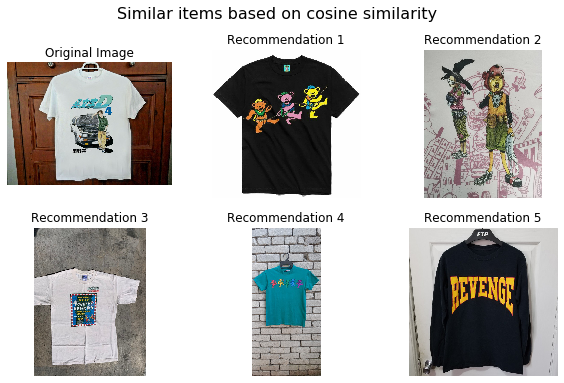

In [72]:
# Find cosine-similar items using the full dataset

display_cosim_recs(kdf.loc[127:127], kdf)

In [ ]:
The second data subset includes only number of likes, price, size and vintage- a binary classifier. On visual inspection, both seemed to perform relatively well but the simpler data returned more aesthetically similar items. 

Image 8054 cosine similarity: [[0.99982659]]
Image 6397 cosine similarity: [[0.99969474]]
Image 113 cosine similarity: [[0.99925202]]
Image 5443 cosine similarity: [[0.99890477]]
Image 2829 cosine similarity: [[0.99890477]]
Image 4154 cosine similarity: [[0.99862508]]
Image 494 cosine similarity: [[0.99801698]]
Image 4041 cosine similarity: [[0.99800668]]
Image 714 cosine similarity: [[0.9979939]]
Standard Deviation of likes in Recommendation Group: 0.08364695798623134
Difference in mean price and target item: 127    0.013933
Name: Price, dtype: float64


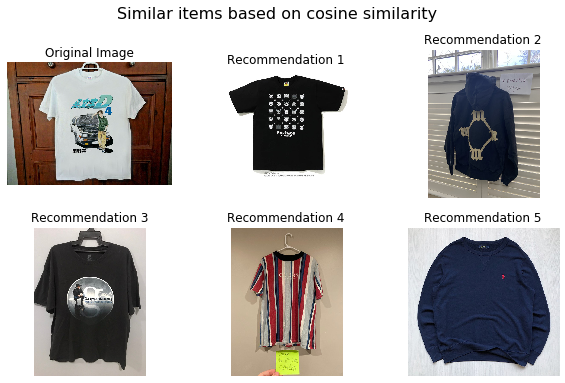

In [73]:
# Find cosine-similar items using the abbreviated dataset

display_cosim_recs(simple_df.loc[127:127], simple_df)

For a second test, I chose a very expensive listing ($2500) to see what the two datasets would pick up. Up first is the full dataset. It returned an interesting mix of different styles.

Image 3748 cosine similarity: [[0.60443535]]
Image 659 cosine similarity: [[0.58703793]]
Image 4226 cosine similarity: [[0.57200558]]
Image 6307 cosine similarity: [[0.54601192]]
Image 5917 cosine similarity: [[0.53630307]]
Image 6042 cosine similarity: [[0.49779624]]
Image 5436 cosine similarity: [[0.49770672]]
Image 5591 cosine similarity: [[0.49287588]]
Image 1582 cosine similarity: [[0.48692371]]
Standard Deviation of likes in Recommendation Group: 0.3343553985497701
Difference in mean price and target item: 4363   -0.11982
Name: Price, dtype: float64


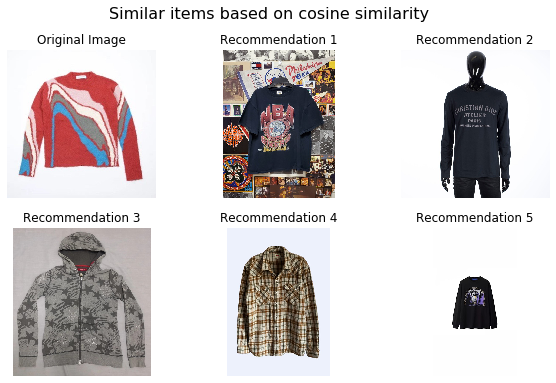

In [74]:
display_cosim_recs(kdf.loc[4363:4363], kdf)

The simple model, where price is a bigger factor (because there are far fewer features) seemed to perform even worse at getting similarly priced items. I think for this to function properly I need to backtrack and scale my data.

Image 6288 cosine similarity: [[1.]]
Image 4363 cosine similarity: [[1.]]
Image 2394 cosine similarity: [[1.]]
Image 1247 cosine similarity: [[0.99999117]]
Image 4081 cosine similarity: [[0.99999115]]
Image 7002 cosine similarity: [[0.99998425]]
Image 3968 cosine similarity: [[0.99997548]]
Image 3439 cosine similarity: [[0.99997548]]
Image 1621 cosine similarity: [[0.99997548]]
Standard Deviation of likes in Recommendation Group: 5.887846720064156e-17
Difference in mean price and target item: 4363    0.005109
Name: Price, dtype: float64


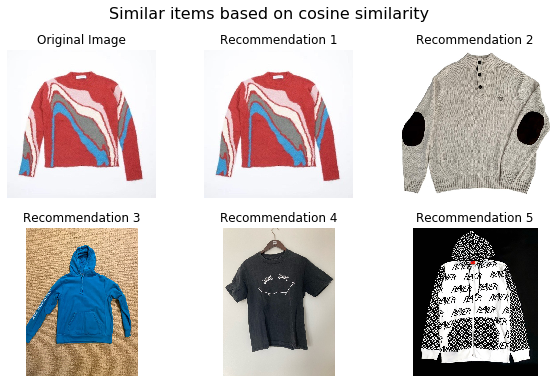

In [75]:
display_cosim_recs(simple_df.loc[4363:4363], simple_df)

## Nearest Neighbors

In [34]:
knn = NearestNeighbors(n_neighbors=8, n_jobs=-1)
knn.fit(simple_df)

knn.kneighbors(X= simple_df.loc[127:127], n_neighbors=6, return_distance=True)[1]

array([[ 127, 8054, 6397,  113, 2829, 5443]])

In [106]:
def KNN_recs(input_row, dataframe, n_neighbors):
    knn = NearestNeighbors(n_neighbors= n_neighbors, n_jobs=-1)
    knn.fit(dataframe)

    recs = knn.kneighbors(X= input_row, n_neighbors=500, return_distance=False)
    return recs

In [67]:
def display_KNN_recs(input_row, dataframe, n_neighbors):
    
    # Take indices from nearest neighbors
    indices = KNN_recs(input_row, dataframe, n_neighbors)[0]
    
    # Create an empty list and append the images from each indice to it, starting
    # with the input row
    images = []
    test_i = []
    for i in indices:
        images.append(Image.open(f'./src/images/{i}.jpg'))
        test_i.append(i)
    for i in test_i:
        print(f'Image {i} cosine similarity:', cosine_similarity(input_row, dataframe.loc[i:i]))
              
    print('Standard Deviation of likes in Recommendation Group:', dataframe['FollowerCount'][test_i].std())
    print('Difference in mean price and target item:', (input_row.Price - dataframe.Price[test_i].mean()))
              
    # Display the images
    fig, ax = plt.subplots(2, 3, figsize = (10,6))
    fig.suptitle('Similar items based on Nearest Neighbors', size = 16)
    ax[0,0].imshow(images[0])
    ax[0,0].axis('off')
    ax[0,0].set_title('Original Image')
    ax[0,1].imshow(images[1])
    ax[0,1].axis('off')
    ax[0,1].set_title('Recommendation 1')
    ax[0,2].imshow(images[2])
    ax[0,2].axis('off')
    ax[0,2].set_title('Recommendation 2')
    ax[1,0].imshow(images[3])
    ax[1,0].axis('off')
    ax[1,0].set_title('Recommendation 3')
    ax[1,1].imshow(images[4])
    ax[1,1].axis('off')
    ax[1,1].set_title('Recommendation 4')
    ax[1,2].imshow(images[5])
    ax[1,2].axis('off')
    ax[1,2].set_title('Recommendation 5')
    plt.show()
    
    return 

Image 127 cosine similarity: [[1.]]
Image 2006 cosine similarity: [[0.89308757]]
Image 3684 cosine similarity: [[0.86431153]]
Image 5447 cosine similarity: [[0.83896043]]
Image 9703 cosine similarity: [[0.83014489]]
Image 9387 cosine similarity: [[0.82708954]]
Standard Deviation of likes in Recommendation Group: 1.05777743945999
Difference in mean price and target item: 127    0.750271
Name: Price, dtype: float64


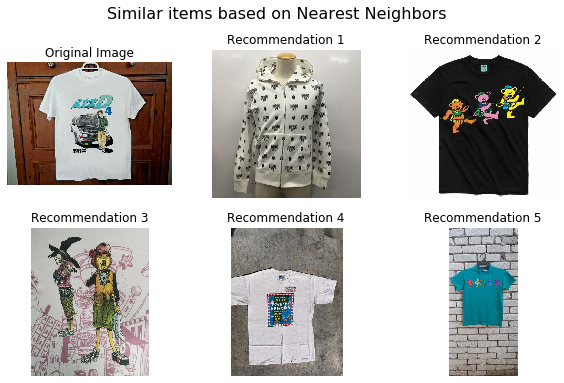

In [68]:
display_KNN_recs(kdf.loc[127:127], kdf, 7)

Image 127 cosine similarity: [[1.]]
Image 8054 cosine similarity: [[0.99982659]]
Image 6397 cosine similarity: [[0.99969474]]
Image 113 cosine similarity: [[0.99925202]]
Image 2829 cosine similarity: [[0.99890477]]
Image 5443 cosine similarity: [[0.99890477]]
Standard Deviation of likes in Recommendation Group: 0.054637964160610425
Difference in mean price and target item: 127    0.019506
Name: Price, dtype: float64


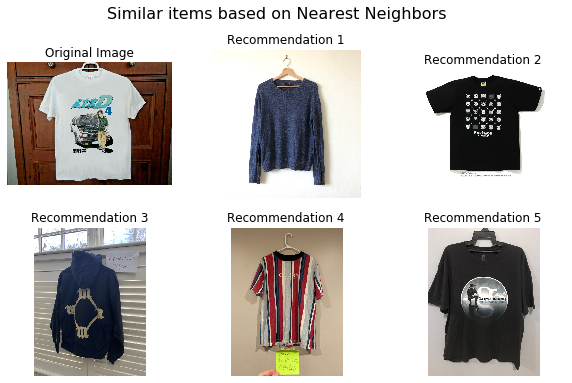

In [69]:
display_KNN_recs(simple_df.loc[127:127], simple_df, 7)

In [160]:
def ensemble_method_recs(input_row, dataframe, color_dataframe, n_clusters= 18):
    cos_sim = []
    color_output = []
    knn = list(KNN_recs(input_row, dataframe, 500)[0])
    kmean = cluster_recommendations(input_row, dataframe, n_clusters=n_clusters)

    for i in dataframe.index:
        try:
            color_output.append((sum(
                [dist.euclidean(color_dataframe['0'][input_row.index[0]], color_dataframe['0'][i]),
                dist.euclidean(color_dataframe['1'][input_row.index[0]], color_dataframe['1'][i]),
                dist.euclidean(color_dataframe['2'][input_row.index[0]], color_dataframe['2'][i])]), i))
        except KeyError:
            continue
    
        try:
            cos_sim.append((cosine_similarity(input_row, dataframe.iloc[i].values.reshape(1,-1)), i))
        
        except IndexError:
            continue
    cos_sim = [i[1] for i in sorted(cos_sim[:-2:])][0:500]
    color_output = [i[1] for i in sorted(color_output)][0:500]

    total_recs = Counter(cos_sim) + Counter(color_output) + Counter(knn) + Counter(kmean)

    return np.where(pd.Series(total_recs) > 1)
    # return the recs where 4 is 1st, 3 is second, etc. 
    # Leave room for weighting the models? weight params and if clauses
    #create a ranking system based on sorting the lists i.e. the highest cosine similarity gets a score of 10,000, the lowest 1. Add the of the lists together and sort, returning indices of the highest values. Create a dataframe using df.loc[[indices]] print stats- std of Followers, avg cos distance, av euclidean color distance, followed by each item's photo and summary data



In [ ]:
Create functions to find various stats between an input item and the dataframe- cosine similarity, KNN, assigning to a cluster, linear relationships with PCA if possible

Create function to ouput item photos, name, size, price and link from original dataframe along with the summary data 

In [131]:
kdf.FollowerCount.std()

29.889027881318835

In [134]:
kdf.loc[[12,34,567]].std()

Price              241.160389
Sold               126.633329
Feedback            66.460515
CurrentListings     22.188586
FollowerCount       67.825757
                      ...    
within               0.000000
working              0.000000
worn                 0.000000
you                  0.156615
your                 0.000000
Length: 149, dtype: float64